# Mašinsko učenje – Projekat

**Studentica:** Hasnija Selmanović  
**Asistentica:** Adisa Bolić

---

Cilj projekta je izgradnja modela koji predviđa prisutnost srčane bolesti na osnovu medicinskih podataka.  
Korišćeni algoritmi: **Logistička regresija** i **Random Forest**.  
Podaci su analizirani, očišćeni i pripremljeni kroz vizualizaciju, enkodiranje i skaliranje.

Evaluacija modela je sprovedena pomoću klasifikacionih metrika i ROC krive.


## Eksploracija i osnovna analiza podataka

U ovom dijelu vrši se učitavanje skupa podataka i prikaz osnovnih informacija:
- Prvih nekoliko redova tabele (`head`)
- Tipovi podataka i broj nenedostajućih vrednosti (`info`)
- Provjera da li postoje nedostajuće vrijednosti (`isnull().sum()`)



In [5]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heart.csv')
df.head()

df.info()

df.isnull().sum()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


###Vizualizacija kategorijalnih promenljivih
U ovom delu vizualizujemo raspodelu svih kategorijalnih promenljivih u skupu podataka: Sex, ChestPainType, FastingBS, RestingECG, ExerciseAngina i ST_Slope.

Pomoću countplot funkcije prikazujemo koliko puta se pojavljuju pojedinačne vrednosti svake promenljive.

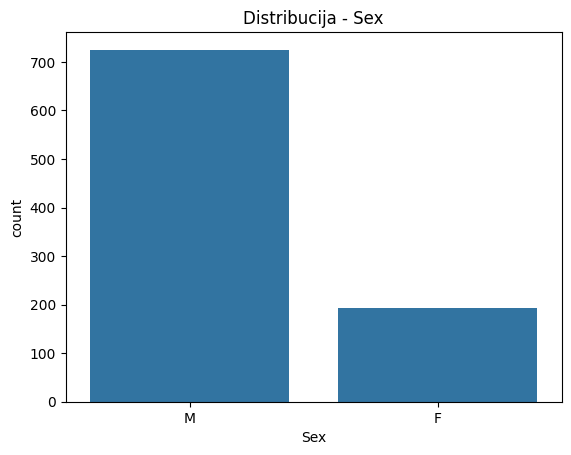

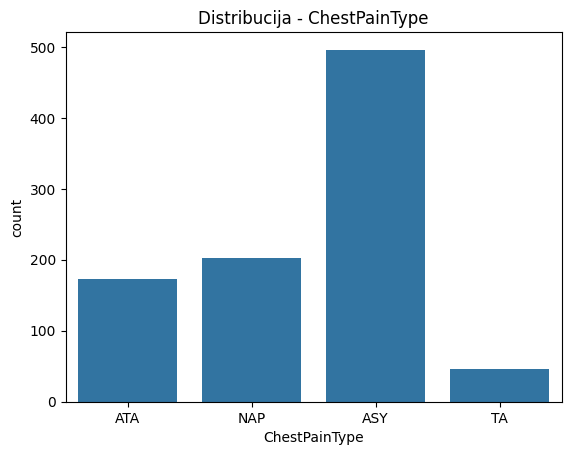

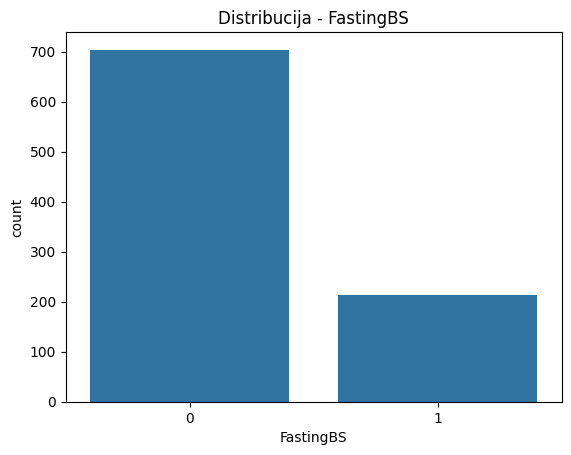

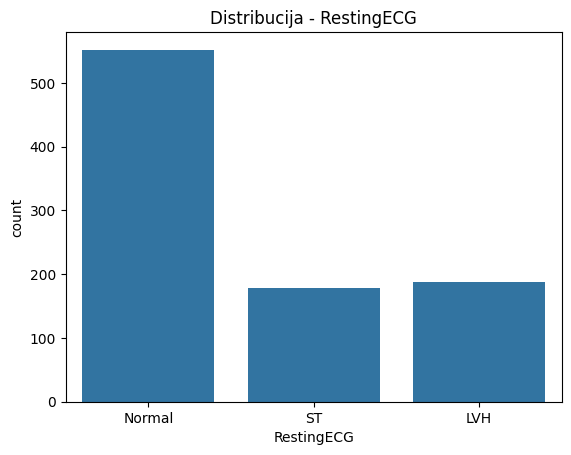

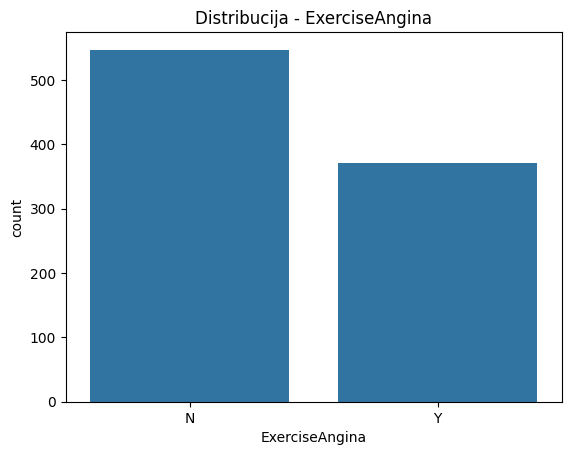

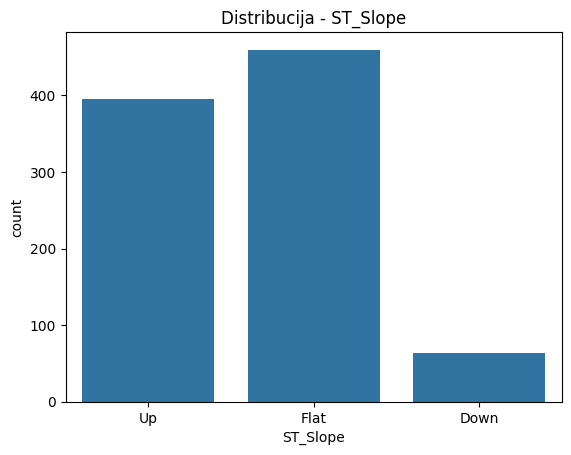

In [6]:
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in categorical:
    sns.countplot(x=col, data=df)
    plt.title(f'Distribucija - {col}')
    plt.show()

###Korelacija numeričkih promenljivih
U ovom dijelu analiziramo međusobnu korelaciju numeričkih promenljivih i njihovu povezanost sa ciljnim atributom HeartDisease.

Korelacija meri jačinu linearne veze između promenljivih i prikazuje se vrednostima između -1 i 1:

vrednosti blizu 1 označavaju snažnu pozitivnu povezanost,

vrednosti blizu -1 označavaju snažnu negativnu povezanost,

vrednosti blizu 0 ukazuju na slabu ili nikakvu linearnu vezu.

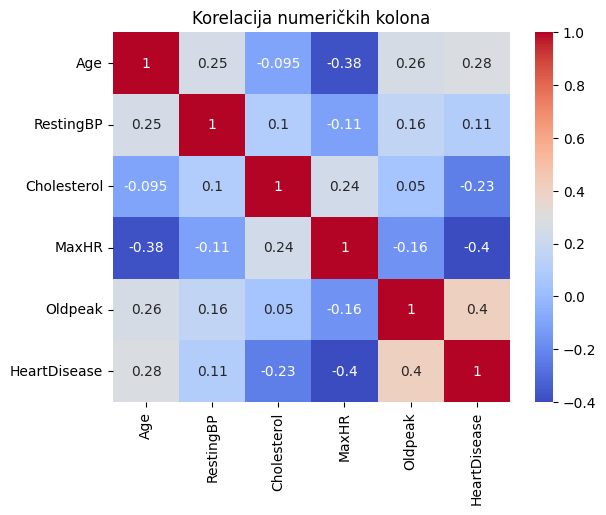

In [7]:
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

sns.heatmap(df[numerical + ['HeartDisease']].corr(), annot=True, cmap='coolwarm')
plt.title('Korelacija numeričkih kolona')
plt.show()

###Enkodiranje kategorijalnih promenljivih
Pošto algoritmi mašinskog učenja očekuju numeričke ulaze, kategorijalne promenljive (ChestPainType, RestingECG, ExerciseAngina, ST_Slope) potrebno je pretvoriti u numerički format.

Za to koristimo One-Hot Encoding putem funkcije pd.get_dummies, pri čemu se za svaku kategoriju kreira nova binarna kolona

In [36]:

df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)
df_encoded.head()

df_encoded['Sex'].fillna(df_encoded['Sex'].mode()[0], inplace=True)

df_encoded['Sex'] = df_encoded['Sex'].map({'M': 1, 'F': 0})
df_encoded.head()


/tmp/ipython-input-36-2871340858.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded['Sex'].fillna(df_encoded['Sex'].mode()[0], inplace=True)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0.0,0,True,False,False,True,False,False,False,True
1,49,0,160,180,0,156,1.0,1,False,True,False,True,False,False,True,False
2,37,1,130,283,0,98,0.0,0,True,False,False,False,True,False,False,True
3,48,0,138,214,0,108,1.5,1,False,False,False,True,False,True,True,False
4,54,1,150,195,0,122,0.0,0,False,True,False,True,False,False,False,True


###Skaliranje numeričkih vrednosti i enkodiranje pola
Numeričke promenljive (Age, RestingBP, Cholesterol, MaxHR, Oldpeak) se skaliraju korišćenjem StandardScaler klase.
Ova transformacija standardizuje podatke tako da imaju:

srednju vrednost (mean) = 0

standardnu devijaciju (std) = 1

Skaliranje je važno kako bi svi atributi imali uporedivu težinu prilikom treniranja modela, naročito kod algoritama koji zavise od udaljenosti ili gradijenata.

Takođe, vršimo binarnu enkodaciju kolone Sex, gde vrednosti:

M (muško) postaju 1

F (žensko) postaju 0

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_encoded[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']] = scaler.fit_transform(
    df_encoded[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]
)

df_encoded.head()


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,1,0.410909,0.825070,0,1.382928,-0.832432,0,True,False,False,True,False,False,False,True
1,-0.478484,0,1.491752,-0.171961,0,0.754157,0.105664,1,False,True,False,True,False,False,True,False
2,-1.751359,1,-0.129513,0.770188,0,-1.525138,-0.832432,0,True,False,False,False,True,False,False,True
3,-0.584556,0,0.302825,0.139040,0,-1.132156,0.574711,1,False,False,False,True,False,True,True,False
4,0.051881,1,0.951331,-0.034755,0,-0.581981,-0.832432,0,False,True,False,True,False,False,False,True


###Podela podataka na trening i test skup
Nakon pripreme podataka, vršimo podelu skupa na:

trening skup (80%) – koristi se za obučavanje modela

test skup (20%) – koristi se za evaluaciju performansi modela na neviđenim podacima

Za ciljne i ulazne promenljive:

X sadrži sve ulazne atribute (bez HeartDisease)

y sadrži ciljnu promenljivu HeartDisease

Argument stratify=y osigurava da distribucija ciljne klase bude ravnomerno zastupljena i u trening i u test skupu.

In [38]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

###Logistička regresija – treniranje i evaluacija modela
U ovom dijelu primjenjujemo logističku regresiju, jedan od najčešće korišćenih algoritama za binarne klasifikacione probleme.

Logistička regresija procenjuje verovatnoću da instanca pripada klasi 1 (u ovom slučaju, da pacijent ima srčanu bolest). Na osnovu toga donosi klasifikacionu odluku (0 ili 1).

Nakon treniranja modela (fit), sprovodimo evaluaciju pomoću sledećih metrika:

Confusion matrix – prikazuje tačne i pogrešne klasifikacije

Classification report – uključuje preciznost (precision), odziv (recall), F1-score i tačnost (accuracy)

ROC-AUC score – meri sposobnost modela da razlikuje klase, gde 1 znači savršen model, a 0.5 nasumično pogađanje

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Popunjavanje NaN vrednosti
X_train.fillna(X_train.mean(numeric_only=True), inplace=True)
X_test.fillna(X_test.mean(numeric_only=True), inplace=True)

# Treniranje modela
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Evaluacija
print("Logistic Regression:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, model_lr.predict_proba(X_test)[:, 1]))



Logistic Regression:
[[68 14]
 [ 7 95]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

ROC-AUC: 0.9308943089430894


###Random Forest – treniranje i evaluacija modela
U ovom delu koristimo Random Forest algoritam, koji predstavlja ansambl metodu baziranu na većem broju stabala odlučivanja (decision trees).
Svakim treniranjem model pravi više stabala na različitim podskupovima podataka i kombinuje njihove predikcije kako bi poboljšao tačnost i smanjio overfitting.

Random Forest je poznat po svojoj robusnosti i često daje bolje rezultate od pojedinačnih modela.

Za evaluaciju koristimo:

Confusion matrix

Classification report (precision, recall, F1-score, accuracy)

ROC-AUC score – pokazuje koliko model dobro razdvaja klase

In [40]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1]))

Random Forest:
[[69 13]
 [ 8 94]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        82
           1       0.88      0.92      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

ROC-AUC: 0.9315518890483022


###ROC kriva – vizuelno poređenje modela
Na ovom mjestu prikazujemo ROC krive (Receiver Operating Characteristic) za oba modela:

Logističku regresiju

Random Forest

ROC kriva prikazuje odnos između:

True Positive Rate (TPR) – osjetljivost (sensitivity)

False Positive Rate (FPR) – lažno pozitivna stopa

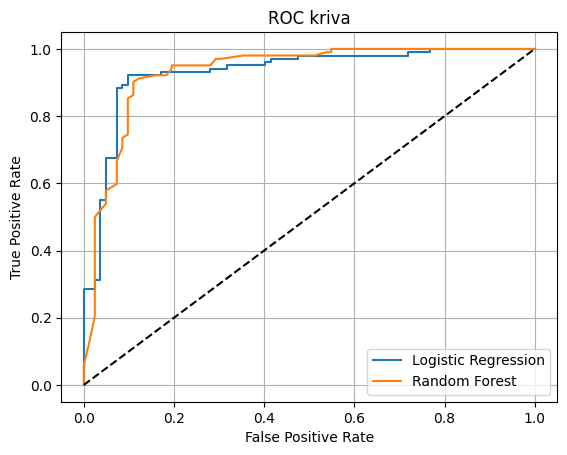

In [41]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, model_lr.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:,1])

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1], [0,1], 'k--')  # dijagonala
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kriva')
plt.legend()
plt.grid()
plt.show()